# Multi-layer Perceptron

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
def Generar_train_test_sets():
    train = np.array([])
    test = np.array([])
    for i in range(k):
        if i in tt:
            if len(test) == 0:
                test = folds[i]
            else:
                test = np.concatenate((test,folds[i]))
        else:
            if len(train) == 0:
                train = folds[i]
            else:
                train = np.concatenate((train,folds[i]))
    return train, test

In [86]:
def Leer_Datos(name, delmt = '\t',head = None):
    data = pd.read_csv(name + '.csv', delimiter = delmt)
    return data

files = ["diabetes","Enfermedad_Cardiaca","iris"]
f = 1
data = Leer_Datos(files[f],'\t')
data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [87]:
data = data.sort_values(by=data.columns[-1])
raw_data = data.values
raw_data_x = raw_data[:,:-1]
raw_data_yl = raw_data[:,-1]
labels =[raw_data_yl[0]]
for ll in raw_data_yl:
    if ll not in labels:
        labels.append(ll)
raw_data_y = np.zeros((len(raw_data_x),len(labels)),dtype=bool)


In [88]:
i = 0
for la in raw_data_yl:
    raw_data_y[i,labels.index(la)] = 1
    i+=1
raw_data_y[-1]

array([False,  True])

In [89]:
raw_data_x = np.array(raw_data_x,dtype=np.float64)
def Normalizar_Datos(arraynp):
#     last = np.array(arraynp[:,-1])
    mean = np.mean(arraynp,0)
    standard = np.std(arraynp,0)
    for i in range(0,arraynp.shape[0]):
        arraynp[i] = np.true_divide((arraynp[i] - mean), standard)
#     arraynp[:,-1] = last[:]
    return arraynp

standard = np.std(raw_data_x,0)
raw_data_x = Normalizar_Datos(raw_data_x)

In [90]:
def Crear_k_folds(data, k =3, classes=2):
    indexs=[]
    for i in range(1,classes+1):
        ind = np.where(np.diff(data[:,-i]))
        for i in ind[0]:
            if i not in indexs:
                indexs.append(i)
    
    indexs= [x+1 for x in indexs]
    indexs.sort()
    print (indexs)
    Groups = np.split(data, indexs)
    
    Parts =[]
    for g in Groups:
        tmp = np.array_split(g, k)
        for p in tmp:
            Parts.append(p)
    
    res = list()
    for i in range(k):
        temp = Parts[i]
        for j in range(1,classes):
            temp = np.concatenate((temp,Parts[i+(k*j)]))

        np.random.shuffle(temp)
        res.append(temp)
    print('rr',len(res))
    return res

# raw_data_x = Normalizar_Datos(raw_data_x)
print(raw_data_x.shape,raw_data_y.shape)
print (raw_data_y[-1])
num_classes = len(raw_data_y[0])
raw_data = np.concatenate((raw_data_x,raw_data_y),axis=1)
print(raw_data.shape)
raw_folds = Crear_k_folds(raw_data,classes=num_classes)

(303, 13) (303, 2)
[False  True]
(303, 15)
[138]
rr 3


In [91]:
def Save_Folds(folds, name, file='/', delt='\t', classes=2):
    for i in range(len(folds)):
        X = folds[i][:,:-(classes)]
        Y = folds[i][:,-(classes):]
        xname = file + name + '_X' + str(i+1) + '.csv'
        yname = file + name + '_Y' + str(i+1) + '.csv'
        np.savetxt(xname, X, delimiter=delt)
        np.savetxt(yname, Y, delimiter=delt)
        
Save_Folds(raw_folds,'enf_cardiaca','folds/',',',num_classes)

In [60]:
def Sigmoidal(x):
    return 1.0 / (1.0+np.exp(-x))

def Derivada_Sigmoidal(x):
    return x * (1.0 - x)

def Calcular_Funcion_Costo(y_p, y):
    a = -np.log(y_p)
#     print ('a',a)
    b = a * y
#     print ('b',b)
    loss = b.mean()
    return loss

def Calcular_Accuracy(X, Y, W):
    y_predict = Sigmoidal(X, W).round()
    count = 0
    for y in (Y-y_predict):
        if 1 not in y:
            count = count + 1
    return (count/len(Y)) * 100

In [53]:
def Forward(X, weights, activations):
    A = X
    activations[0] = A
    for i,w in enumerate(weights):
        h = np.dot(A, w)
        A = Sigmoidal(h)
        activations[i+1] = A
    return A, activations

def Backward(y_p, y, activations, weights, learning,loss):
    delta = (y_p - y) * Derivada_Sigmoidal(activations[-1])
    for i in range(1,len(weights)+1):
        a = activations[-i-1].reshape(activations[-i-1].shape[0],-1)
        d = delta.reshape(delta.shape[0],-1).T
        
        weights[-i] -= learning *(np.dot(a,d))
        dd = Derivada_Sigmoidal(activations[-i-1])
        delta = dd * np.dot(delta,weights[-i].T)
    return weights
         
def Gradiente_Descendiente(X, Y, weights, iteraciones, learning, activations):
    costos = [0] * iteraciones
    for i in range(iteraciones):
        cost = 0
        for j,x in enumerate(X):
            y_p, activation = Forward(x, weights, activations)
            c = Calcular_Funcion_Costo(y_p,Y[j])
            cost += c
            weights = Backward(y_p, Y[j], activations, weights, learning,c)
        costos[i] = cost / (len(X))
    return weights, costos

In [4]:
def Generar_Pesos(layers):
    wei = []
    for l in range(len(layers)-1):
        w = np.random.rand(layers[l],layers[l+1])
        wei.append(w)
    return wei

def Generar_Activaciones(layers):
    act = []
    for l in range(len(layers)):
        a = np.zeros(layers[l])
        act.append(a)
    return act

In [61]:
def Calcular_Accuracy(X, Y, W, A):
    count = 0
    for i,x in enumerate(X):
        y_predict,_ = Forward(x,W,A)
        y_predict = np.around(y_predict)
        yy = Y[i]
        y = y_predict - yy

        cc = y_predict == yy
        if (y_predict == yy).all():
            count+=1
    return (count/len(Y)) * 100

### Experimento 1

In [6]:
def Get_train_test_sets(name, orden=1, k=3, deli='\t'):
    train_X = np.array([])
    train_Y = np.array([])
    test_X = np.array([])
    test_Y = np.array([])
    for i in range(k):
        if i+1 == orden:
            test_X = pd.read_csv(name+'_X'+str(i+1)+'.csv').values
            test_Y = pd.read_csv(name+'_Y'+str(i+1)+'.csv').values
        else:
            tx = pd.read_csv(name+'_X'+str(i+1)+'.csv').values
            ty = pd.read_csv(name+'_Y'+str(i+1)+'.csv').values
            if train_X.shape[0] == 0:
                train_X = tx
                train_Y = ty
            else:
                train_X = np.concatenate((train_X,tx))
                train_Y = np.concatenate((train_Y,ty))
            
    return train_X, train_Y, test_X, test_Y

import random

def getNeurons(num_layers=1, neurons=[1]):
    lays = []
    for i in range(num_layers):
        lays.append(random.choice(neurons))
    return lays

In [7]:
num_folds = 3
num_hidden_layers = [1,2,3,4]
num_neurons_per_l = [3,4,5]
tasa_aprendisaje = [0.1,0.2,0.3, 0.4, 0.5]#, 0.05, 0.1, 0.2]
num_iteraciones = [200,300, 500, 1000, 2000]

In [9]:
nn = len(num_hidden_layers)*len(tasa_aprendisaje)*len(num_iteraciones)
namefold = 'folds/iris'
# train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, 1, k=num_folds, deli=',')
LLL = getNeurons(2,[4,3,2])
nn

100

In [9]:
accuracies = np.empty((nn,3),dtype=np.float32)
list_layers = []
acc_index=0
acc_max = 0
best_parameters = (0,0,[])
ma_iris = []
dma = []
for l in num_hidden_layers:
    lay = getNeurons(l,num_neurons_per_l)
    matrix_ac = np.random.rand(len(tasa_aprendisaje),len(num_iteraciones),num_folds)
    for k in range(num_folds):
        train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
        layers = [train_X.shape[1]]+lay+[train_Y.shape[1]]
        for i,t in enumerate(tasa_aprendisaje):
            for j,itr in enumerate(num_iteraciones):
                weigths = Generar_Pesos(layers)
                activations = Generar_Activaciones(layers)
                new_Weigths, _ = Gradiente_Descendiente(train_X, train_Y, weigths, itr, t, activations)

                matrix_ac[i,j,k] = Calcular_Accuracy(test_X,test_Y,new_Weigths,activations)
    ma_iris.append((layers,np.mean(matrix_ac,axis=2)))
    print('========',layers,'========')
# print(ma)

======== [4, 3, 3] ========
======== [4, 4, 3, 3] ========
======== [4, 5, 4, 3, 3] ========
======== [4, 5, 4, 3, 5, 3] ========


In [24]:
max_acc = 0
parametrs = (0,0,[])

for ar,M in ma_iris:
    for i in range(len(M)):
        for j in range(len(M[0])):
            if M[i,j] > max_acc:
                max_acc = M[i,j]
                parametrs = (tasa_aprendisaje[i],num_iteraciones[j],ar)
                MM_ = M

print (parametrs,max_acc)

(0.1, 1000, [4, 4, 3, 3]) 98.0


In [25]:
df1 = pd.DataFrame(data = MM_, index= tasa_aprendisaje, columns = num_iteraciones)
df1

,200,300,500,1000,2000
0.1,87.290780,94.539007,95.957447,98.000000,96.666667
0.2,97.333333,97.333333,97.333333,95.957447,97.290780
0.3,97.333333,97.333333,95.872340,98.000000,93.787234
0.4,98.000000,96.666667,93.787234,93.787234,93.744681
0.5,95.333333,96.000000,93.120567,95.205674,94.539007


In [54]:
train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, 1, k=num_folds, deli=',')
layers = [train_X.shape[1]]+[4,3]+[train_Y.shape[1]]
weigths = Generar_Pesos(layers)
activations = Generar_Activaciones(layers)
new_Weigths, costos = Gradiente_Descendiente(train_X, train_Y, weigths, 200, 0.4, activations)

Text(0, 0.5, 'Costo')

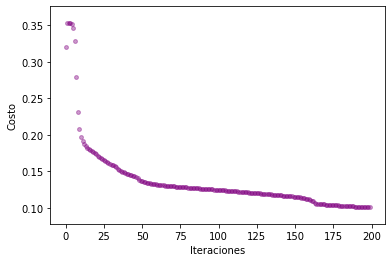

In [55]:
plt.scatter(np.arange(200),costos, s=15,c='purple',alpha=0.4)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')

In [52]:
Calcular_Accuracy(test_X,test_Y,new_Weigths,activations)

0.0

In [24]:
num_folds = 3
num_hidden_layers = [1,2,3,4]
num_neurons_per_l = [4,5,6,7]
tasa_aprendisaje = [0.1,0.2,0.3, 0.4, 0.5]#, 0.05, 0.1, 0.2]
num_iteraciones = [200,300, 500, 1000, 2000]

In [25]:
nn = len(num_hidden_layers)*len(tasa_aprendisaje)*len(num_iteraciones)
namefold = 'folds/enf_cardiaca'
LLL = getNeurons(2,[4,3,2])
nn

100

In [15]:
accuracies = np.empty((nn,3),dtype=np.float32)
list_layers = []
acc_index=0
acc_max = 0
best_parameters = (0,0,[])
ma_card = []
dma = []
for l in num_hidden_layers:
    lay = getNeurons(l,num_neurons_per_l)
    matrix_ac = np.random.rand(len(tasa_aprendisaje),len(num_iteraciones),num_folds)
    for k in range(num_folds):
        train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
        layers = [train_X.shape[1]]+lay+[train_Y.shape[1]]
        for i,t in enumerate(tasa_aprendisaje):
            for j,itr in enumerate(num_iteraciones):
                weigths = Generar_Pesos(layers)
                activations = Generar_Activaciones(layers)
                new_Weigths, _ = Gradiente_Descendiente(train_X, train_Y, weigths, itr, t, activations)

                matrix_ac[i,j,k] = Calcular_Accuracy(test_X,test_Y,new_Weigths,activations)
    ma_card.append((layers,np.mean(matrix_ac,axis=2)))
    print('========',layers,'========')
# print(ma)

======== [13, 5, 2] ========
======== [13, 7, 5, 2] ========
======== [13, 6, 4, 6, 2] ========
======== [13, 6, 5, 6, 7, 2] ========


In [26]:
max_acc = 0
parametrs = (0,0,[])
for ar,M in ma_card:
    for i in range(len(M)):
        for j in range(len(M[0])):
            if M[i,j] > max_acc:
                max_acc = M[i,j]
                parametrs = (tasa_aprendisaje[i],num_iteraciones[j],ar)
                MM_=M
print (parametrs, max_acc)

(0.1, 200, [13, 7, 5, 2]) 83.66666666666667


In [27]:
df2 = pd.DataFrame(data = MM_, index= tasa_aprendisaje, columns = num_iteraciones)
df2

,200,300,500,1000,2000
0.1,83.666667,81.000000,79.000000,80.666667,78.666667
0.2,80.333333,81.666667,76.666667,80.333333,77.666667
0.3,78.666667,80.000000,78.333333,78.666667,77.000000
0.4,79.666667,80.333333,79.666667,75.666667,76.333333
0.5,81.000000,77.000000,81.333333,77.000000,79.666667


In [58]:
train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, 1, k=num_folds, deli=',')
layers = [train_X.shape[1]]+[7,5]+[train_Y.shape[1]]
weigths = Generar_Pesos(layers)
activations = Generar_Activaciones(layers)
new_Weigths, costos = Gradiente_Descendiente(train_X, train_Y, weigths, 200, 0.1, activations)

Text(0, 0.5, 'Costo')

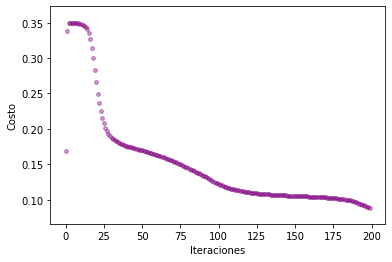

In [59]:
plt.scatter(np.arange(200),costos, s=15,c='purple',alpha=0.4)
plt.xlabel('Iteraciones')
plt.ylabel('Costo')

### Experimento 2

In [36]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [37]:
def toSVM(train, test):
    tr = np.zeros((train.shape[0],))
    ts = np.zeros((test.shape[0],))
    
    for i,r in enumerate(train):
        tr[i] = np.where(r==1)[0]
    for i,s in enumerate(test):
        ts[i] = np.where(s==1)[0]
    return tr,ts

In [38]:
type_kernel = ['linear','poly','sigmoid','rbf']
parameter_C = [0.5,1.0,1.5,2.0,2.5,3.0,10.0]#[1.0,0.5,1.5]
matrix_ac_iris = np.random.rand(len(type_kernel),len(parameter_C),3)
namefold = 'folds/iris'
for k in range(num_folds):
    train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
    train_Y, test_Y = toSVM(train_Y, test_Y)
    for i,ke in enumerate(type_kernel):
        for j,c in enumerate(parameter_C):
            clf = svm.SVC(C=c, kernel = ke,gamma='auto')
            clf.fit(train_X, train_Y)
            matrix_ac_iris[i,j,k] = accuracy_score(test_Y,clf.predict(test_X))
        
matrix_ac_iris

array([[[1.        , 0.9       , 1.        ],
        [0.98      , 0.92      , 1.        ],
        [0.98      , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.9       , 1.        ],
        [1.        , 0.92      , 1.        ]],

       [[0.88      , 0.88      , 0.89361702],
        [0.96      , 0.92      , 0.89361702],
        [0.98      , 0.94      , 0.91489362],
        [0.98      , 0.94      , 0.93617021],
        [0.98      , 0.94      , 0.93617021],
        [0.98      , 0.96      , 0.93617021],
        [0.98      , 0.92      , 0.95744681]],

       [[0.92      , 0.9       , 1.        ],
        [0.9       , 0.88      , 1.        ],
        [0.9       , 0.84      , 0.9787234 ],
        [0.84      , 0.78      , 0.9787234 ],
        [0.82      , 0.76      , 0.9787234 ],
        [0.8       , 0.76      , 0.9787234 ],
        [0.78      , 0.88      , 0.95744681]],

       [[0.96      , 0.92   

In [39]:
print(matrix_ac_iris.shape)
matrix_ac_iris = np.mean(matrix_ac_iris,axis=2)
parametros = (0,0)
for ta in  range(len(type_kernel)):
    for itr in range(len(parameter_C)):
        if(matrix_ac_iris[ta,itr] > matrix_ac_iris[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df1 = pd.DataFrame(data = matrix_ac_iris, index= type_kernel, columns = parameter_C)
print("Mayor accuracy promedio con:",type_kernel[parametros[0]],parameter_C[parametros[1]])
df1

(4, 7, 3)
Mayor accuracy promedio con: rbf 10.0


,0.5,1.0,1.5,2.0,2.5,3.0,10.0
linear,0.966667,0.966667,0.960000,0.966667,0.966667,0.966667,0.973333
poly,0.884539,0.924539,0.944965,0.952057,0.952057,0.958723,0.952482
sigmoid,0.940000,0.926667,0.906241,0.866241,0.852908,0.846241,0.872482
rbf,0.945816,0.966241,0.973333,0.966667,0.960000,0.959574,0.986667


In [40]:
type_kernel = ['linear','poly','sigmoid','rbf']
parameter_C = [0.5,1.0,1.5,2.0,2.5,3.0,10.0]#[1.0,0.5,1.5]
matrix_ac_card = np.random.rand(len(type_kernel),len(parameter_C),3)
namefold = 'folds/enf_cardiaca'
for k in range(num_folds):
    train_X, train_Y, test_X, test_Y = Get_train_test_sets(namefold, k+1, k=num_folds, deli=',')
    train_Y, test_Y = toSVM(train_Y, test_Y)
    for i,ke in enumerate(type_kernel):
        for j,c in enumerate(parameter_C):
            clf = svm.SVC(C=c, kernel = ke,gamma='auto')
            clf.fit(train_X, train_Y)
            matrix_ac_card[i,j,k] = accuracy_score(test_Y,clf.predict(test_X))
        
matrix_ac_card

array([[[0.85, 0.83, 0.82],
        [0.85, 0.82, 0.81],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.85, 0.82, 0.82],
        [0.86, 0.83, 0.82]],

       [[0.77, 0.76, 0.77],
        [0.83, 0.8 , 0.8 ],
        [0.85, 0.79, 0.81],
        [0.86, 0.78, 0.8 ],
        [0.86, 0.8 , 0.79],
        [0.85, 0.81, 0.79],
        [0.81, 0.8 , 0.75]],

       [[0.82, 0.8 , 0.84],
        [0.84, 0.84, 0.82],
        [0.83, 0.82, 0.81],
        [0.84, 0.83, 0.83],
        [0.83, 0.84, 0.81],
        [0.84, 0.8 , 0.8 ],
        [0.82, 0.8 , 0.86]],

       [[0.87, 0.81, 0.84],
        [0.85, 0.84, 0.81],
        [0.84, 0.85, 0.83],
        [0.83, 0.85, 0.8 ],
        [0.83, 0.85, 0.79],
        [0.82, 0.83, 0.77],
        [0.8 , 0.8 , 0.77]]])

In [41]:
print(matrix_ac_card.shape)
matrix_ac_card = np.mean(matrix_ac_card,axis=2)
parametros = (0,0)
for ta in  range(len(type_kernel)):
    for itr in range(len(parameter_C)):
        if(matrix_ac_card[ta,itr] > matrix_ac_card[parametros[0],parametros[1]]):
            parametros = (ta, itr)

df1 = pd.DataFrame(data = matrix_ac_card, index= type_kernel, columns = parameter_C)
print("Mayor accuracy promedio con:",type_kernel[parametros[0]],parameter_C[parametros[1]])
df1

(4, 7, 3)
Mayor accuracy promedio con: rbf 0.5


,0.5,1.0,1.5,2.0,2.5,3.0,10.0
linear,0.833333,0.826667,0.830000,0.830000,0.830000,0.830000,0.836667
poly,0.766667,0.810000,0.816667,0.813333,0.816667,0.816667,0.786667
sigmoid,0.820000,0.833333,0.820000,0.833333,0.826667,0.813333,0.826667
rbf,0.840000,0.833333,0.840000,0.826667,0.823333,0.806667,0.790000
